In [ ]:
import os
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score

np.random.seed(42)

NOTEBOOK_DIR = Path.cwd()
DATA_ROOT = NOTEBOOK_DIR / 'dataset2-master' / 'dataset2-master' / 'images' / 'TEST_SIMPLE'

assert DATA_ROOT.exists(), f"Dataset folder not found: {DATA_ROOT}"
print('Using dataset:', DATA_ROOT)

image_paths = sorted([p for p in DATA_ROOT.rglob('*.jpeg')])
print('Total images found:', len(image_paths))

MAX_IMAGES = 120
image_paths = image_paths[:MAX_IMAGES]
print('Images used for evaluation:', len(image_paths))

Using dataset: c:\Ayush files\Python P\Project_1\Project_2\dataset2-master\dataset2-master\images\TEST_SIMPLE
Total images found: 71
Images used for evaluation: 71


In [2]:
def preprocess_image(img_bgr, size=(128, 128)):
    img = cv2.resize(img_bgr, size, interpolation=cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb


def build_features(img_rgb):
    """Simple feature stack: RGB + Lab + normalized XY coordinates."""
    h, w, _ = img_rgb.shape
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    yy, xx = np.mgrid[0:h, 0:w]
    x_norm = (xx / max(w - 1, 1)).astype(np.float32)
    y_norm = (yy / max(h - 1, 1)).astype(np.float32)

    feats = np.concatenate([
        img_rgb.astype(np.float32),
        lab.astype(np.float32),
        (x_norm[..., None] * 255.0),
        (y_norm[..., None] * 255.0),
    ], axis=2)
    return feats.reshape(-1, feats.shape[-1])


def cluster_to_nucleus_and_cytoplasm(img_rgb, labels):
    """
    Map cluster ids to nucleus / cytoplasm using Lab channels:
    - nucleus tends to have higher a-channel (purple-magenta)
    - cytoplasm is generally brighter than nucleus (higher L)
    """
    h, w, _ = img_rgb.shape
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L = lab[..., 0].reshape(-1)
    a = lab[..., 1].reshape(-1)

    unique = np.unique(labels)
    cluster_stats = []
    for c in unique:
        idx = labels == c
        cluster_stats.append({
            'cluster': c,
            'mean_a': float(a[idx].mean()) if np.any(idx) else -np.inf,
            'mean_L': float(L[idx].mean()) if np.any(idx) else -np.inf,
            'count': int(np.sum(idx))
        })

    # nucleus = cluster with highest a (purple)
    nucleus_cluster = max(cluster_stats, key=lambda d: d['mean_a'])['cluster']

    # cytoplasm = among remaining, brightest cluster
    remaining = [d for d in cluster_stats if d['cluster'] != nucleus_cluster]
    cytoplasm_cluster = max(remaining, key=lambda d: d['mean_L'])['cluster'] if remaining else nucleus_cluster

    nucleus_mask = (labels.reshape(h, w) == nucleus_cluster).astype(np.uint8)
    cytoplasm_mask = (labels.reshape(h, w) == cytoplasm_cluster).astype(np.uint8)

    return nucleus_mask, cytoplasm_mask


def boundary_mask(binary_mask):
    kernel = np.ones((3, 3), np.uint8)
    grad = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_GRADIENT, kernel)
    return (grad > 0).astype(np.uint8)


def boundary_accuracy(pred_boundary, ref_boundary):
    """IoU over boundary pixels (simple boundary accuracy score)."""
    p = pred_boundary.reshape(-1)
    r = ref_boundary.reshape(-1)
    return jaccard_score(r, p, zero_division=1)


def reference_masks_from_color(img_rgb):
    """
    Proxy reference masks (since no GT masks in this dataset):
    - nucleus: high 'a' in Lab + sufficient saturation in HSV
    - cell area: saturation threshold
    - cytoplasm: cell area minus nucleus
    """
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    a = lab[..., 1]
    s = hsv[..., 1]

    nucleus_ref = ((a > np.percentile(a, 65)) & (s > np.percentile(s, 45))).astype(np.uint8)
    cell_ref = (s > np.percentile(s, 35)).astype(np.uint8)
    cytoplasm_ref = ((cell_ref == 1) & (nucleus_ref == 0)).astype(np.uint8)

    # clean small blobs
    kernel = np.ones((3, 3), np.uint8)
    nucleus_ref = cv2.morphologyEx(nucleus_ref, cv2.MORPH_OPEN, kernel)
    nucleus_ref = cv2.morphologyEx(nucleus_ref, cv2.MORPH_CLOSE, kernel)
    cytoplasm_ref = cv2.morphologyEx(cytoplasm_ref, cv2.MORPH_OPEN, kernel)

    return nucleus_ref, cytoplasm_ref

In [3]:
def segment_kmeans(img_rgb, n_clusters=3):
    feats = build_features(img_rgb)
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(feats)
    return cluster_to_nucleus_and_cytoplasm(img_rgb, labels)


def fcm_numpy(features, n_clusters=3, m=2.0, max_iter=60, error=1e-4):
    """Minimal FCM implementation with NumPy."""
    n_samples = features.shape[0]

    # membership matrix U: shape (n_clusters, n_samples)
    U = np.random.rand(n_clusters, n_samples).astype(np.float64)
    U /= np.sum(U, axis=0, keepdims=True)

    eps = 1e-8
    prev_obj = None

    for _ in range(max_iter):
        Um = U ** m
        centers = (Um @ features) / (np.sum(Um, axis=1, keepdims=True) + eps)

        # distances shape (n_clusters, n_samples)
        d = np.linalg.norm(features[None, :, :] - centers[:, None, :], axis=2) + eps

        # objective
        obj = np.sum((U ** m) * (d ** 2))

        # update U
        ratio = (d[:, None, :] / d[None, :, :]) ** (2.0 / (m - 1.0))
        U = 1.0 / np.sum(ratio, axis=1)

        if prev_obj is not None and abs(prev_obj - obj) < error:
            break
        prev_obj = obj

    labels = np.argmax(U, axis=0)
    return labels


def segment_fcm(img_rgb, n_clusters=3, m=2.0):
    feats = build_features(img_rgb).astype(np.float64)
    labels = fcm_numpy(feats, n_clusters=n_clusters, m=m, max_iter=60, error=1e-4)
    return cluster_to_nucleus_and_cytoplasm(img_rgb, labels)

In [4]:
rows = []
examples = []

for i, p in enumerate(image_paths):
    img_bgr = cv2.imread(str(p))
    if img_bgr is None:
        continue

    img_rgb = preprocess_image(img_bgr, size=(128, 128))

    # Reference (proxy)
    nuc_ref, cyto_ref = reference_masks_from_color(img_rgb)
    nuc_ref_b = boundary_mask(nuc_ref)
    cyto_ref_b = boundary_mask(cyto_ref)

    # K-Means (hard clustering)
    nuc_km, cyto_km = segment_kmeans(img_rgb, n_clusters=3)
    nuc_km_b = boundary_mask(nuc_km)
    cyto_km_b = boundary_mask(cyto_km)

    # FCM (soft clustering, final hard label via argmax)
    nuc_fcm, cyto_fcm = segment_fcm(img_rgb, n_clusters=3, m=2.0)
    nuc_fcm_b = boundary_mask(nuc_fcm)
    cyto_fcm_b = boundary_mask(cyto_fcm)

    km_nuc_acc = boundary_accuracy(nuc_km_b, nuc_ref_b)
    km_cyto_acc = boundary_accuracy(cyto_km_b, cyto_ref_b)
    fcm_nuc_acc = boundary_accuracy(nuc_fcm_b, nuc_ref_b)
    fcm_cyto_acc = boundary_accuracy(cyto_fcm_b, cyto_ref_b)

    rows.append({
        'image': p.name,
        'class': p.parent.name,
        'km_nucleus_boundary_iou': km_nuc_acc,
        'km_cytoplasm_boundary_iou': km_cyto_acc,
        'fcm_nucleus_boundary_iou': fcm_nuc_acc,
        'fcm_cytoplasm_boundary_iou': fcm_cyto_acc,
        'km_mean_boundary_iou': (km_nuc_acc + km_cyto_acc) / 2,
        'fcm_mean_boundary_iou': (fcm_nuc_acc + fcm_cyto_acc) / 2,
    })

    if len(examples) < 6:
        examples.append({
            'img': img_rgb,
            'nuc_ref': nuc_ref,
            'cyto_ref': cyto_ref,
            'nuc_km': nuc_km,
            'cyto_km': cyto_km,
            'nuc_fcm': nuc_fcm,
            'cyto_fcm': cyto_fcm,
            'name': p.name,
            'class': p.parent.name
        })

results_df = pd.DataFrame(rows)
results_df.head()

,image,class,km_nucleus_boundary_iou,km_cytoplasm_boundary_iou,fcm_nucleus_boundary_iou,fcm_cytoplasm_boundary_iou,km_mean_boundary_iou,fcm_mean_boundary_iou
0,_0_5239.jpeg,EOSINOPHIL,0.046927,0.034490,0.050963,0.022488,0.040709,0.036726
1,_10_5476.jpeg,EOSINOPHIL,0.052694,0.043105,0.045831,0.044786,0.047900,0.045308
2,_11_9310.jpeg,EOSINOPHIL,0.028223,0.023551,0.034019,0.030835,0.025887,0.032427
3,_12_2599.jpeg,EOSINOPHIL,0.024594,0.018864,0.028045,0.023301,0.021729,0.025673
4,_1_5031.jpeg,EOSINOPHIL,0.053704,0.024859,0.024527,0.016915,0.039281,0.020721


In [5]:
summary = pd.DataFrame({
    'Metric': ['Nucleus Boundary IoU', 'Cytoplasm Boundary IoU', 'Mean Boundary IoU'],
    'K-Means': [
        results_df['km_nucleus_boundary_iou'].mean(),
        results_df['km_cytoplasm_boundary_iou'].mean(),
        results_df['km_mean_boundary_iou'].mean()
    ],
    'FCM': [
        results_df['fcm_nucleus_boundary_iou'].mean(),
        results_df['fcm_cytoplasm_boundary_iou'].mean(),
        results_df['fcm_mean_boundary_iou'].mean()
    ]
})

summary['Winner'] = np.where(summary['FCM'] > summary['K-Means'], 'FCM', 'K-Means')
summary

,Metric,K-Means,FCM,Winner
0,Nucleus Boundary IoU,0.043983,0.033714,K-Means
1,Cytoplasm Boundary IoU,0.030091,0.028819,K-Means
2,Mean Boundary IoU,0.037037,0.031267,K-Means


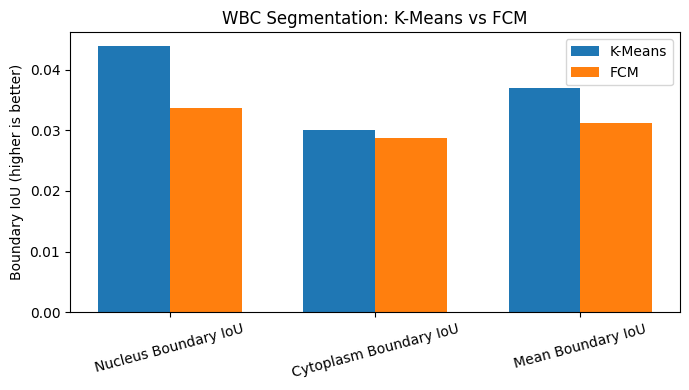

In [6]:
plt.figure(figsize=(7, 4))
bar_x = np.arange(len(summary))
width = 0.35

plt.bar(bar_x - width/2, summary['K-Means'], width, label='K-Means')
plt.bar(bar_x + width/2, summary['FCM'], width, label='FCM')

plt.xticks(bar_x, summary['Metric'], rotation=15)
plt.ylabel('Boundary IoU (higher is better)')
plt.title('WBC Segmentation: K-Means vs FCM')
plt.legend()
plt.tight_layout()
plt.show()

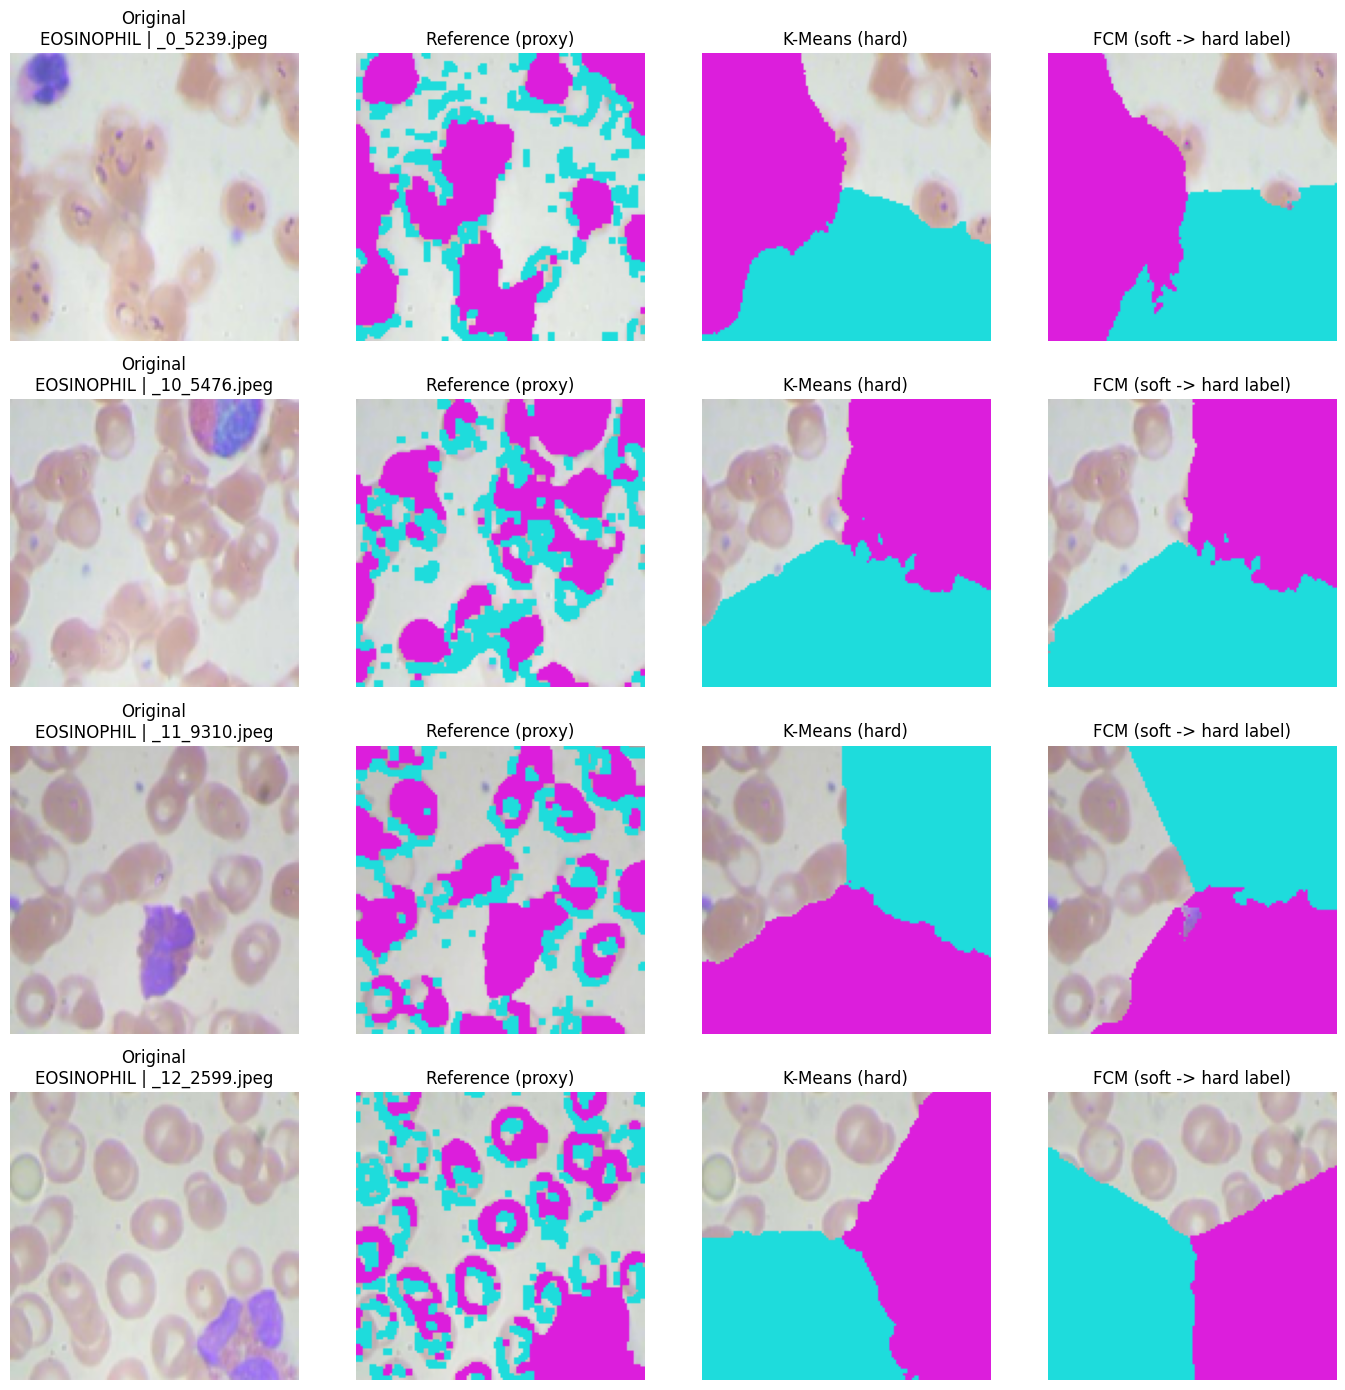

In [7]:
def overlay_masks(img_rgb, nucleus_mask, cytoplasm_mask):
    out = img_rgb.copy()
    # nucleus in magenta, cytoplasm in cyan
    out[nucleus_mask == 1] = (220, 30, 220)
    out[cytoplasm_mask == 1] = (30, 220, 220)
    return out

n_show = min(4, len(examples))
fig, axes = plt.subplots(n_show, 4, figsize=(14, 3.5 * n_show))
if n_show == 1:
    axes = np.expand_dims(axes, 0)

for i in range(n_show):
    ex = examples[i]
    axes[i, 0].imshow(ex['img'])
    axes[i, 0].set_title(f"Original\n{ex['class']} | {ex['name']}")
    axes[i, 0].axis('off')

    ref_overlay = overlay_masks(ex['img'], ex['nuc_ref'], ex['cyto_ref'])
    axes[i, 1].imshow(ref_overlay)
    axes[i, 1].set_title('Reference (proxy)')
    axes[i, 1].axis('off')

    km_overlay = overlay_masks(ex['img'], ex['nuc_km'], ex['cyto_km'])
    axes[i, 2].imshow(km_overlay)
    axes[i, 2].set_title('K-Means (hard)')
    axes[i, 2].axis('off')

    fcm_overlay = overlay_masks(ex['img'], ex['nuc_fcm'], ex['cyto_fcm'])
    axes[i, 3].imshow(fcm_overlay)
    axes[i, 3].set_title('FCM (soft -> hard label)')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

In [8]:
out_csv = NOTEBOOK_DIR / 'wbc_kmeans_vs_fcm_boundary_results.csv'
results_df.to_csv(out_csv, index=False)
summary_csv = NOTEBOOK_DIR / 'wbc_kmeans_vs_fcm_summary.csv'
summary.to_csv(summary_csv, index=False)

print('Saved:', out_csv)
print('Saved:', summary_csv)

best = summary.loc[summary['Metric'] == 'Mean Boundary IoU', 'Winner'].iloc[0]
print('\nOverall winner (Mean Boundary IoU):', best)

Saved: c:\Ayush files\Python P\Project_1\Project_2\wbc_kmeans_vs_fcm_boundary_results.csv
Saved: c:\Ayush files\Python P\Project_1\Project_2\wbc_kmeans_vs_fcm_summary.csv

Overall winner (Mean Boundary IoU): K-Means
